In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import *

import matplotlib.pyplot as plt

# Get simulator backends
qasmsim = Aer.get_backend('qasm_simulator')
backend_options = {"method": "stabilizer"}

# p1 ~ single qubit gate error (u1, u2, u3)
# p2 ~ two qubit gate error (cx)
# q ~ symmetric readout error (measure)
def make_noise_model(p1, p2, q):
    model = noise.noise_model.NoiseModel()
    perror1 = noise.errors.pauli_error([('I', 1.0-p1), ('X', p1/3.0), ('Y', p1/3.0), ('Z', p1/3.0)])
    perror2 = noise.errors.pauli_error([('II', 1.0-p2), ('IX', p2/15.0), ('IY', p2/15.0), ('IZ', p2/15.0),
                                        ('XI', p2/15.0), ('XX', p2/15.0), ('XY', p2/15.0), ('XZ', p2/15.0),
                                        ('YI', p2/15.0), ('YX', p2/15.0), ('YY', p2/15.0), ('YZ', p2/15.0),
                                        ('ZI', p2/15.0), ('ZX', p2/15.0), ('ZY', p2/15.0), ('ZZ', p2/15.0)])
    rerror = noise.errors.readout_error.ReadoutError([[1.0-q, q], [q, 1.0-q]])
    model.add_all_qubit_quantum_error(perror1, ['h','id'])
    model.add_all_qubit_quantum_error(perror2, ['cx'])
    model.add_all_qubit_readout_error(rerror)
    return model

def ghz_from_swaps(n):
    q = QuantumRegister(n, 'q')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(q, c)
    mid = int(n/2 - 1)
    qc.h(q[mid])
    qc.cx(q[mid], q[mid+1])
    for i in range(mid+1,n-1):
        qc.cx(q[n-i-1],q[n-i-2])
        qc.cx(q[i],q[i+1])
        for j in range(n-i,i):
            qc.i(q[j])
    qc.barrier(q)
    qc.measure(q,c)
    return qc

def ghz_from_parity(n):
    q = QuantumRegister(2*n-1, 'q')
    c = ClassicalRegister(2*n-1, 'c')
    qc2 = QuantumCircuit(q, c)
    for i in range(2*n-1):
        if i % 2 == 0:
            qc2.h(q[i])
    for i in range(2*n-1):
        if i % 2 == 1:
            qc2.cx(q[i-1],q[i])
        if i == 2*n-2:
            qc2.i(q[i])
    for i in range(2*n-1):
        if i == 0:
            qc2.i(q[i])
        if i % 2 == 1:
            qc2.cx(q[i+1],q[i])
    qc2.barrier(q)
    qc2.measure(q,c)
    return qc2

OrderedDict([('measure', 6), ('cx', 5), ('id', 2), ('h', 1), ('barrier', 1)])


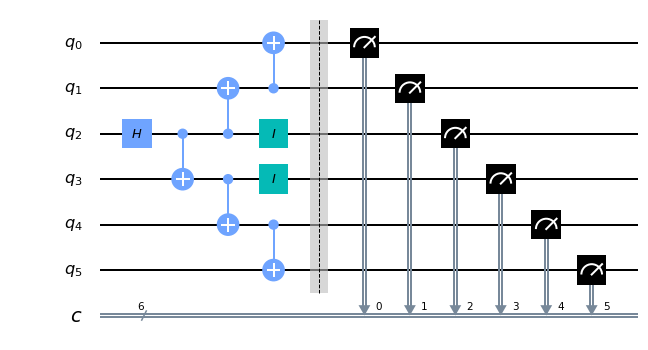

In [2]:
# Prepare an n-qubit GHZ state in depth n/2 + 1, n even
# idles : (n/2-1)(n/2-2) = n*n/4-1.5*n+2 for n >= 6, otherwise 0
# cnots : n - 1
# h : 1
# size = n*n/4-n/2+2 for n >= 6
circuit = ghz_from_swaps(6)
print(circuit.count_ops())
circuit.draw(output="mpl")

OrderedDict([('measure', 11), ('cx', 10), ('h', 6), ('id', 2), ('barrier', 1)])


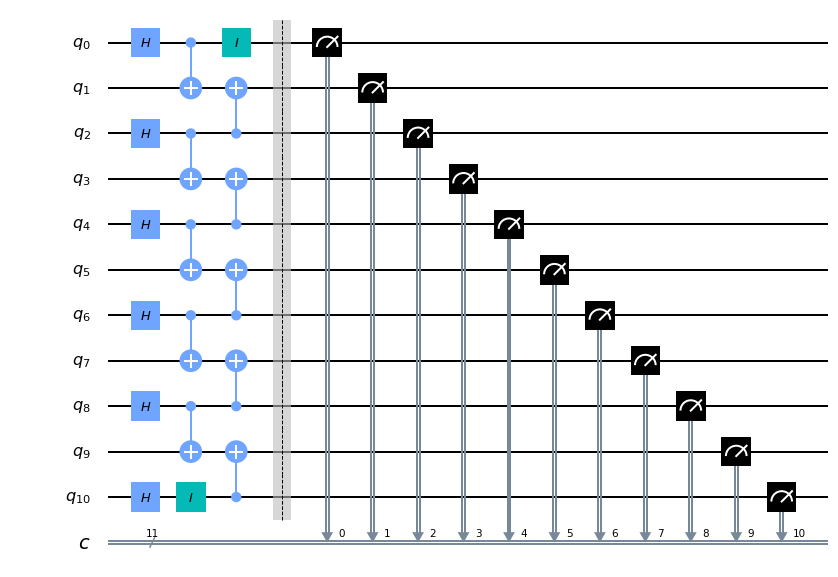

In [3]:
# Prepare an n-qubit GHZ state in depth 3, n even
# id : 2
# cnot : 2*n - 2
# h : n
# measure : n - 1
# size = 4*n - 1
circuit2 = ghz_from_parity(6)
print(circuit2.count_ops())
circuit2.draw(output="mpl")

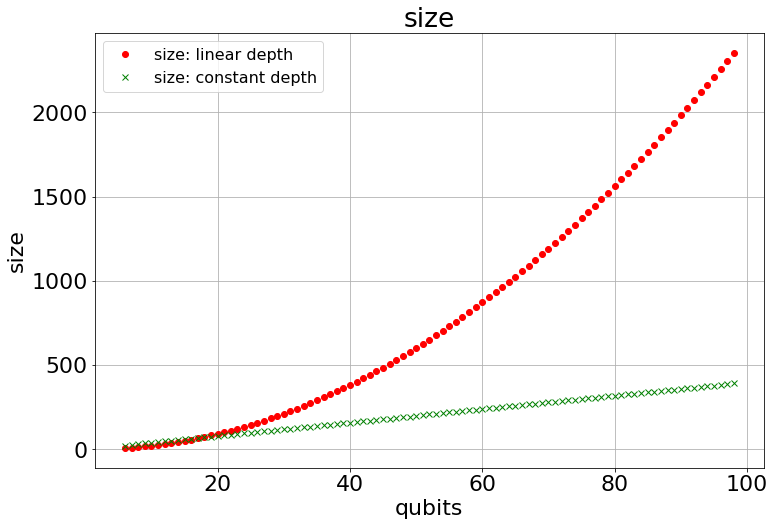

In [4]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
nvals = list(range(6,99))
plt.plot(nvals,[x*x/4-x/2+2 for x in nvals],'ro', label= 'size: linear depth')
plt.plot(nvals,[4*x-1 for x in nvals],'gx', label= 'size: constant depth')
plt.grid(which='major',axis='both')
plt.title('size')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.xlabel('qubits')
plt.ylabel('size')
plt.show()

In [5]:
# total variation distance to GHZ
def tvd(counts, n, shots):
    return 0.5*(abs(counts['0'*n]/shots-0.5)+abs(counts['1'*n]/shots-0.5))

0.032


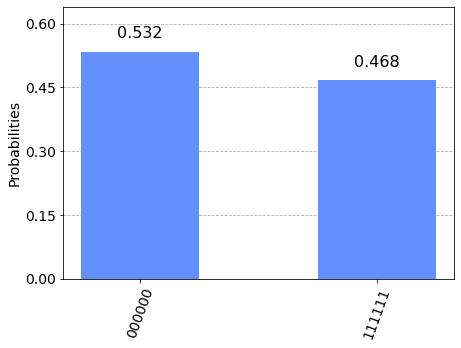

In [6]:
job = execute(circuit, qasmsim, shots=1000, backend_options=backend_options)
result = job.result()
count = result.get_counts(circuit)
#print(count)
print(tvd(count, 6, 1000))
plot_histogram(count)

0.008000000000000007


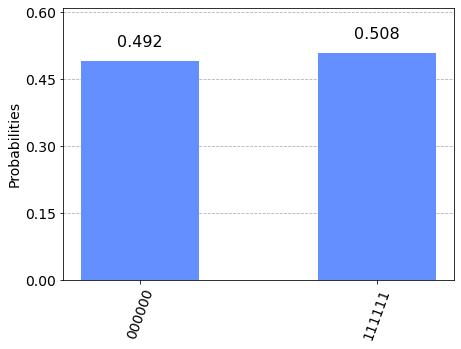

In [7]:
job = execute(circuit2, qasmsim, shots=1000, backend_options=backend_options)
result = job.result()
count = result.get_counts(circuit2)
num = 6
newcount = {"0"*num:0, "1"*num:0}
for x in count.items():
    s = x[0]
    v = x[1]
    sp = [int(s[i]) for i in range(len(s))]
    for i in range(2*num-1):
        if i % 2 == 1:
            if sp[i] == 1:  # if eig(ZZ)=-1
                for j in range(i):  # flip all bits "above" the parity check
                    if j % 2 == 0:
                        sp[j] = (sp[j] + 1) % 2
    dat = [sp[k] for k in range(0,2*num-1,2)]
    spp = "".join(map(str,dat))
    newcount[spp] = newcount[spp] + v
#print(newcount)
print(tvd(newcount, num, 1000))
plot_histogram(newcount)

In [24]:
model = make_noise_model(0.01, 0.01, 0.01)

In [27]:
error_swap=[]
for num in range(2,60,2):
    circuit = ghz_from_swaps(num)
    result_noise = execute(circuit, qasmsim, 
                            noise_model=model,
                            basis_gates=model.basis_gates,
                            shots=1000,backend_options=backend_options).result()
    noise_counts = result_noise.get_counts(circuit)
    error_swap.append(tvd(noise_counts, num, 1000))
    

In [28]:
error_parity=[]
for num in range(2,60,2):
    circuit2 = ghz_from_parity(num)
    result_noise2 = execute(circuit2, qasmsim, 
                            noise_model=model,
                            basis_gates=model.basis_gates,
                            shots=1000,backend_options=backend_options).result()
    noise_counts2 = result_noise2.get_counts(circuit2)
    newcount = {}
    for x in noise_counts2.items():
        s = x[0]
        v = x[1]
        sp = [int(s[i]) for i in range(len(s))]
        for i in range(2*num-1):
            if i % 2 == 1:
                if sp[i] == 1:  # if eig(ZZ)=-1
                    for j in range(i):  # flip all bits "above" the parity check
                        if j % 2 == 0:
                            sp[j] = (sp[j] + 1) % 2
        dat = [sp[k] for k in range(0,2*num-1,2)]
        spp = "".join(map(str,dat))
        if spp in newcount:
            newcount[spp] = newcount[spp] + v
        else:
            newcount[spp] = v
    error_parity.append(tvd(newcount, num, 1000))

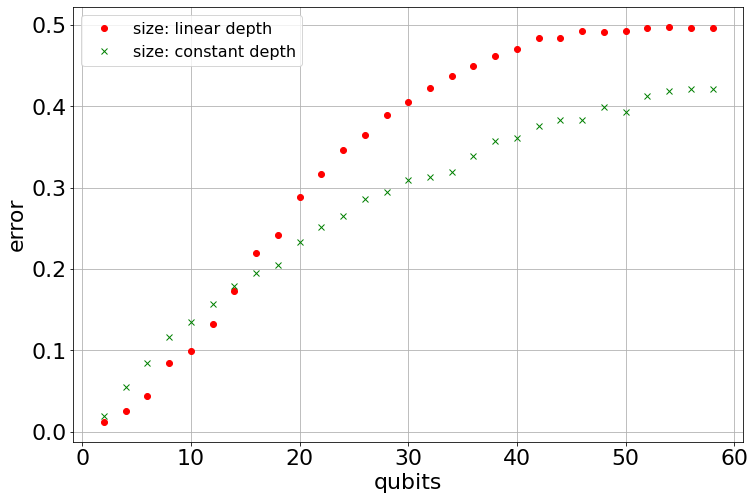

In [30]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
nvals = list(range(2,60,2))
plt.plot(nvals,error_swap,'ro', label= 'size: linear depth')
plt.plot(nvals,error_parity,'gx', label= 'size: constant depth')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.xlabel('qubits')
plt.ylabel('error')
plt.show()